In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
df_raw = pd.read_csv('/content/drive/My Drive/merged_XGB_data.csv')

In [57]:
mapping = {-1: 2, 0: 1, 1: 0}
df_raw['target'] = df_raw['target'].map(mapping)

In [58]:
print("Shape du dataset original:", df_raw.shape)
print("Colonnes:", df_raw.columns.tolist())

# Séparer les features et la target
X_original = df_raw.drop(['target','stock_id'], axis=1)
y = df_raw['target']

print(f"\nDistribution of the target:\n{y.value_counts()}")

Shape du dataset original: (26594, 15)
Colonnes: ['stock_id', 'day_cos', 'close_lag1', 'volume_lag1', 'RSI_lag1', 'ADX_lag1', 'MACD_Signal_lag1', 'MACD_Hist_lag1', 'CCI_lag1', 'SlowD_lag1', 'OBV_lag1', 'day_var_range_lag1', 'Bband_width_lag1', 'day_diff_lag1', 'target']

Distribution of the target:
target
0    11999
2    10913
1     3682
Name: count, dtype: int64


In [59]:
df_clustering = X_original.copy()

# Normalisation pour le clustering
scaler_clustering = StandardScaler()
X_scaled_clustering = scaler_clustering.fit_transform(df_clustering)

print(f"\nDataset normalisé pour clustering: {X_scaled_clustering.shape}")


Dataset normalisé pour clustering: (26594, 13)


In [73]:
# Copier le dataset pour HMM
df_hmm = X_original.copy()

# Normalisation pour HMM
scaler_hmm = StandardScaler()
X_scaled_hmm = scaler_hmm.fit_transform(df_hmm)

print(f"\nDataset normalisé pour HMM: {X_scaled_hmm.shape}")

# Définir le nombre d'états cachés
n_states = 15  # Vous pouvez ajuster ce nombre
print(f"Nombre d'états cachés: {n_states}")


Dataset normalisé pour HMM: (26594, 13)
Nombre d'états cachés: 15


In [74]:
print("\nEntraînement du HMM (cela peut prendre du temps)...")
model_hmm = hmm.GaussianHMM(
    n_components=n_states,
    covariance_type="diag",  # 'diag', 'full', 'tied', 'spherical'
    n_iter=100,
    random_state=42,
    verbose=True
)

# Entraîner le HMM
model_hmm.fit(X_scaled_hmm)



Entraînement du HMM (cela peut prendre du temps)...


         1 -497088.57843606             +nan
         2 -347002.92351995 +150085.65491611
         3 -297443.95524090  +49558.96827905
         4 -274292.32184681  +23151.63339409
         5 -261404.92031326  +12887.40153355
         6 -249763.06956846  +11641.85074480
         7 -241040.31014668   +8722.75942178
         8 -230727.79674649  +10312.51340019
         9 -221985.23685313   +8742.55989336
        10 -214281.06169272   +7704.17516041
        11 -206144.88512027   +8136.17657245
        12 -199055.95807907   +7088.92704121
        13 -194969.22253716   +4086.73554191
        14 -192325.21253198   +2644.01000517
        15 -186206.36200857   +6118.85052341
        16 -184941.12380898   +1265.23819959
        17 -183838.78786054   +1102.33594844
        18 -182568.42759809   +1270.36026245
        19 -180794.08493818   +1774.34265991
        20 -179669.69624672   +1124.38869146
        21 -179337.93057551    +331.76567121
        22 -179090.76472648    +247.16584903
        23

GaussianHMM(n_components=15, n_iter=100, random_state=42, verbose=True)

In [75]:
hidden_states = model_hmm.predict(X_scaled_hmm)

print(f"\nDistribution des états cachés:")
unique_states, counts = np.unique(hidden_states, return_counts=True)
for state, count in zip(unique_states, counts):
    print(f"  État {state}: {count} samples ({count/len(hidden_states)*100:.2f}%)")

# Calculer les probabilités des états
state_probabilities = model_hmm.predict_proba(X_scaled_hmm)

print(f"\nShape des probabilités: {state_probabilities.shape}")


Distribution des états cachés:
  État 0: 1527 samples (5.74%)
  État 1: 2549 samples (9.58%)
  État 2: 2731 samples (10.27%)
  État 3: 777 samples (2.92%)
  État 4: 1618 samples (6.08%)
  État 5: 3036 samples (11.42%)
  État 6: 1094 samples (4.11%)
  État 7: 1366 samples (5.14%)
  État 8: 1973 samples (7.42%)
  État 9: 3563 samples (13.40%)
  État 10: 1085 samples (4.08%)
  État 11: 1191 samples (4.48%)
  État 12: 2181 samples (8.20%)
  État 13: 1033 samples (3.88%)
  État 14: 870 samples (3.27%)

Shape des probabilités: (26594, 15)


In [76]:
print("\n" + "="*60)
print("CRÉATION DES FEATURES HMM")
print("="*60)

# Ajouter au dataframe original
df_raw['hmm_state'] = hidden_states

# Ajouter les probabilités de chaque état
for i in range(n_states):
    df_raw[f'hmm_prob_state_{i}'] = state_probabilities[:, i]

# Calculer l'entropie des probabilités (incertitude)
entropy = -np.sum(state_probabilities * np.log(state_probabilities + 1e-10), axis=1)
df_raw['hmm_entropy'] = entropy

# Calculer la probabilité maximale (confiance)
df_raw['hmm_max_prob'] = np.max(state_probabilities, axis=1)

# Features de transition d'état
df_raw['hmm_state_changed'] = (df_raw['hmm_state'] != df_raw['hmm_state'].shift(1)).astype(int)

# Durée dans l'état actuel
df_raw['hmm_state_duration'] = df_raw.groupby(
    (df_raw['hmm_state'] != df_raw['hmm_state'].shift()).cumsum()
).cumcount() + 1

print(f"\nNouvelles features HMM créées:")
hmm_features = [col for col in df_raw.columns if 'hmm' in col]
for feature in hmm_features:
    print(f"  - {feature}")



CRÉATION DES FEATURES HMM

Nouvelles features HMM créées:
  - hmm_state
  - hmm_prob_state_0
  - hmm_prob_state_1
  - hmm_prob_state_2
  - hmm_prob_state_3
  - hmm_prob_state_4
  - hmm_prob_state_5
  - hmm_prob_state_6
  - hmm_prob_state_7
  - hmm_prob_state_8
  - hmm_prob_state_9
  - hmm_prob_state_10
  - hmm_prob_state_11
  - hmm_prob_state_12
  - hmm_prob_state_13
  - hmm_prob_state_14
  - hmm_prob_state_15
  - hmm_prob_state_16
  - hmm_prob_state_17
  - hmm_prob_state_18
  - hmm_prob_state_19
  - hmm_entropy
  - hmm_max_prob
  - hmm_state_changed
  - hmm_state_duration


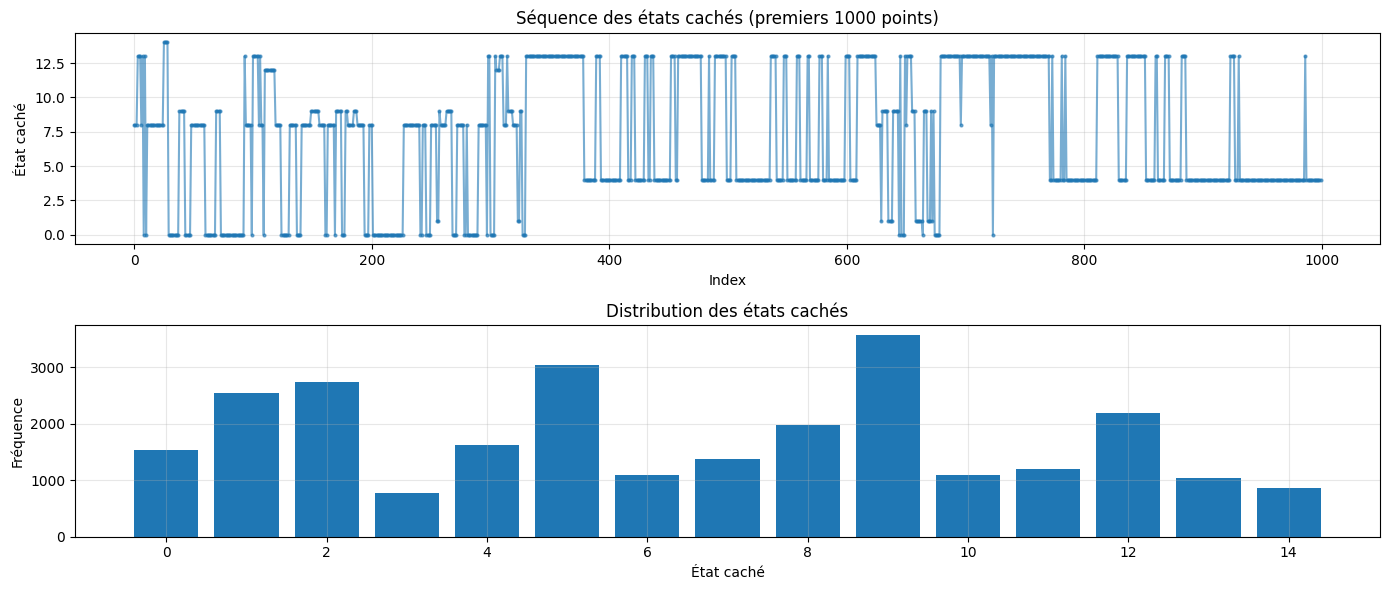

In [77]:
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(df_raw.index[:1000], hidden_states[:1000], 'o-', markersize=2, alpha=0.6)
plt.xlabel('Index')
plt.ylabel('État caché')
plt.title('Séquence des états cachés (premiers 1000 points)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.bar(unique_states, counts)
plt.xlabel('État caché')
plt.ylabel('Fréquence')
plt.title('Distribution des états cachés')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [78]:
print("\nStatistiques de la target par état HMM:")
state_target_stats = df_raw.groupby('hmm_state')['target'].agg(['mean', 'std', 'count'])
print(state_target_stats)



Statistiques de la target par état HMM:
               mean       std  count
hmm_state                           
0          1.049116  0.958960   1527
1          0.905061  0.872352   2549
2          0.968144  0.949692   2731
3          0.949807  0.911724    777
4          1.012361  0.888932   1618
5          0.955534  0.887214   3036
6          0.843693  0.954726   1094
7          0.897511  0.924098   1366
8          0.905727  0.948059   1973
9          0.998877  0.900433   3563
10         0.905069  0.950443   1085
11         0.985726  0.972201   1191
12         1.005502  0.974429   2181
13         0.945789  0.914443   1033
14         0.985057  0.975420    870


In [79]:
features_to_drop = ['target']
X_final = df_raw.drop(features_to_drop, axis=1)
y_final = df_raw['target']

In [80]:
print(f"Shape des features finales: {X_final.shape}")
print(f"\nFeatures HMM ajoutées: {len(hmm_features)}")

# Normalisation pour XGBoost
scaler_xgb = StandardScaler()
X_scaled_xgb = scaler_xgb.fit_transform(X_final)
X_scaled_xgb_df = pd.DataFrame(X_scaled_xgb, columns=X_final.columns, index=X_final.index)

Shape des features finales: (26594, 39)

Features HMM ajoutées: 25


In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_xgb_df, y_final,
    test_size=0.2,
    random_state=42,
    stratify=y_final
)

In [108]:
class_weights = len(y_train) / (3 * y_train.value_counts())
sample_weights = y_train.map(class_weights)

# Paramètres XGBoost optimisés pour classification multiclasse
params = {
    'objective': 'multi:softmax',
    'num_class': 3,  # down, hold, up
    'max_depth': 7,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'min_child_weight': 3,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': 42,
    'tree_method': 'hist',
    'eval_metric': 'aucpr'
}

In [109]:


# Créer et entraîner le modèle
model = xgb.XGBClassifier(**params)

print("Entraînement en cours...")
model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50
)

Entraînement en cours...
[0]	validation_0-aucpr:0.45712	validation_1-aucpr:0.37659
[50]	validation_0-aucpr:0.70013	validation_1-aucpr:0.40990
[99]	validation_0-aucpr:0.81951	validation_1-aucpr:0.41719


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=3, ...)

In [110]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Prédictions de probabilités pour AUC-ROC
y_pred_proba_train = model.predict_proba(X_train)
y_pred_proba_test = model.predict_proba(X_test)

# Accuracy
train_acc = (y_pred_train == y_train).mean()
test_acc = (y_pred_test == y_test).mean()

print(f"\nAccuracy Train: {train_acc:.4f}")
print(f"Accuracy Test: {test_acc:.4f}")

# F1-Score
f1_train_macro = f1_score(y_train, y_pred_train, average='macro')
f1_test_macro = f1_score(y_test, y_pred_test, average='macro')
f1_train_weighted = f1_score(y_train, y_pred_train, average='weighted')
f1_test_weighted = f1_score(y_test, y_pred_test, average='weighted')

print(f"\nF1-Score (Macro) Train: {f1_train_macro:.4f}")
print(f"F1-Score (Macro) Test: {f1_test_macro:.4f}")
print(f"F1-Score (Weighted) Train: {f1_train_weighted:.4f}")
print(f"F1-Score (Weighted) Test: {f1_test_weighted:.4f}")


Accuracy Train: 0.7266
Accuracy Test: 0.4189

F1-Score (Macro) Train: 0.7056
F1-Score (Macro) Test: 0.4009
F1-Score (Weighted) Train: 0.7411
F1-Score (Weighted) Test: 0.4323



Classification Report (Test):
              precision    recall  f1-score   support

    Down (0)       0.53      0.42      0.47      2400
    Hold (1)       0.21      0.48      0.30       736
      Up (2)       0.48      0.40      0.44      2183

    accuracy                           0.42      5319
   macro avg       0.41      0.43      0.40      5319
weighted avg       0.47      0.42      0.43      5319



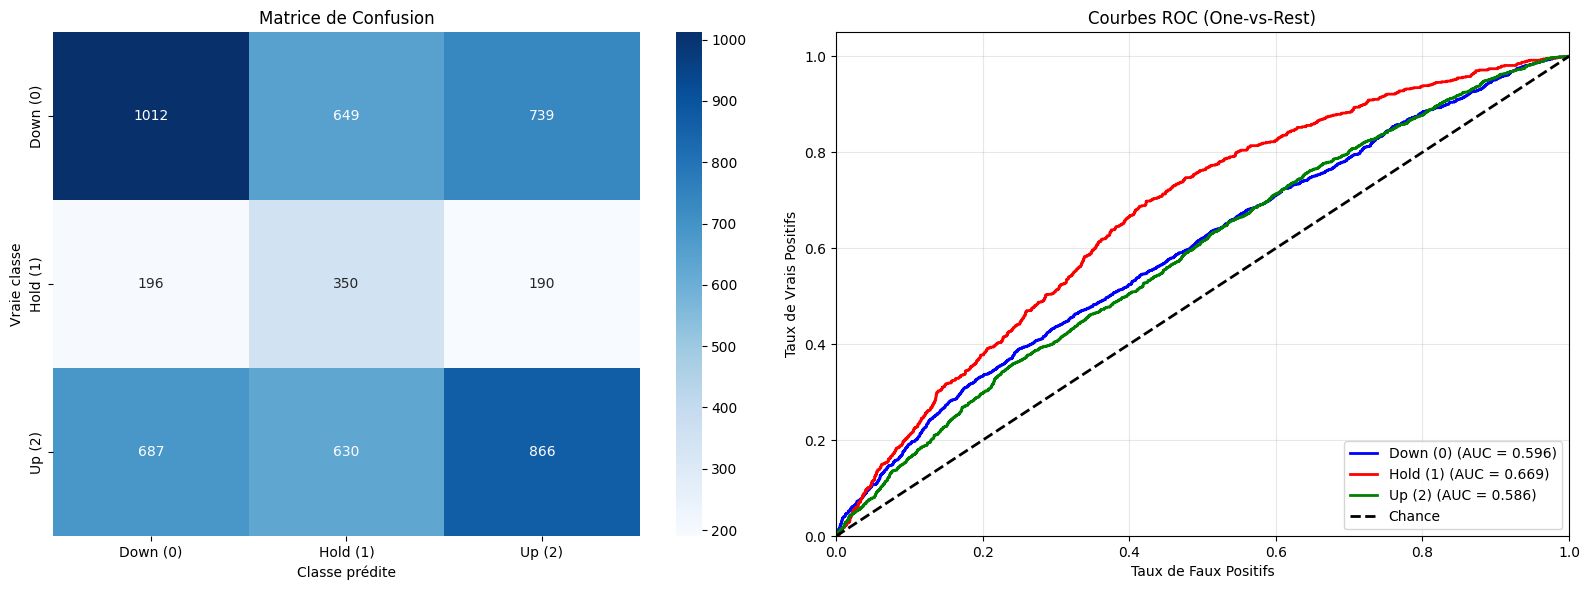

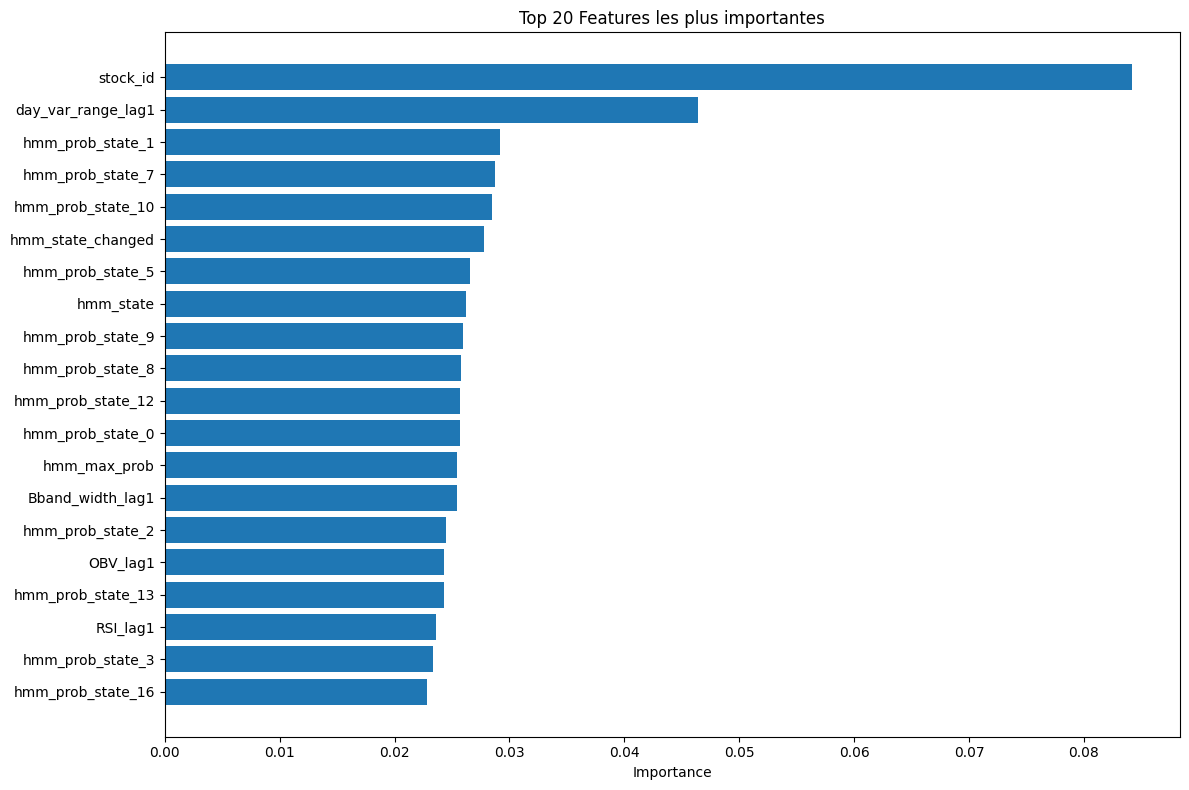

In [111]:
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test,
                          target_names=['Down (0)', 'Hold (1)', 'Up (2)']))

# Matrice de confusion et courbes ROC
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down (0)', 'Hold (1)', 'Up (2)'],
            yticklabels=['Down (0)', 'Hold (1)', 'Up (2)'],
            ax=axes[0])
axes[0].set_title('Matrice de Confusion')
axes[0].set_ylabel('Vraie classe')
axes[0].set_xlabel('Classe prédite')

# ROC Curves (One-vs-Rest)
try:
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

    colors = cycle(['blue', 'red', 'green'])
    class_names = ['Down (0)', 'Hold (1)', 'Up (2)']

    for i, color, class_name in zip(range(3), colors, class_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_test[:, i])
        roc_auc = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, color=color, lw=2,
                    label=f'{class_name} (AUC = {roc_auc:.3f})')

    axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('Taux de Faux Positifs')
    axes[1].set_ylabel('Taux de Vrais Positifs')
    axes[1].set_title('Courbes ROC (One-vs-Rest)')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

except Exception as e:
    axes[1].text(0.5, 0.5, f'Erreur ROC: {e}', ha='center', va='center')

plt.tight_layout()
plt.show()

# Feature importance
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': X_final.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Features les plus importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
